In this Notebook we want to demonstrate what happens to the cumulative number of hospitalisations over a particular time period, when we alter one parameter ceteris paribus. We consider **four scenarios**:
1. Containment (patient zero is local in province g)
2. Protection (patient zero is someplace else in h != g)

In each of these cases, perform a parameter rescaling ...
1. Rescale mobility to and from g (from 1 to 0)
2. Rescale non-home-related social contact (from 1 to 0)

and leave all other parameters intact. This means we have to take the following steps in this particular order:
1. Load all packages. Show the corner plot of the latest calibration
2. Load initial values on January 1st 2020. Let's look at Brussels, and have patient zero in Brussels or in Luxembourg.
2. Load all model data. In particular ...
    - Loop over values for `p`
    - Loop over values for alpha that rescale `Nc_all` = `Nc_home` + `alpha` * (`Nc_schools` + ...)
    - Mobility is average mobility pre-pandemic
    - No vaccinations, no VOCs, no seasonality, ...
    - Either (this is a question) have the best-fit parameter values, or sample from the dict. In the latter case, we need to perform at least 10 and preferably 100 simulations per parameter value.
4. Load the model *without* time-dependent parameter functions
5. Execute the model over *one wave* and look at the cumulative number of hospitalisations at e.g. May 1st
6. Add this number to an array and at the end of the loop, plot the p/alpha array against the cumulative number of hospitalisations

Remaining questions:
1. Should we take one particular set of parameter values, or should we sample from the parameter dict? Choosing the latter would mean that we need many more draws for the relation to converge neatly - but it would look nicer. Choosing the former would mean that the parameters don't really fit together. The cornerplot can be created in `notebooks/calibration/MR-postprocessing-calibration.ipynb`
2. How do we make people act that are forced to stay at home?
    - Either force subjects that stay at home to actually behave according to stay-at-home contact
    - Either have all social contact identical everywhere (standard `Nc_all`)

# Load Python packages

In [1]:
# Load packages
# Established packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom package covid19model
from covid19model.models import models
from covid19model.data import model_parameters, mobility #, sciensano, google
from covid19model.models.utils import initialize_COVID19_SEIQRD_spatial_hybrid_vacc, read_coordinates_place, initial_state
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, make_VOC_function
from covid19model.visualization.output import *

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

In [15]:
# Spatial model settings
agg = 'prov'
space_stratification_size = len(read_coordinates_place(agg=agg))
age_stratification_size=10
dose_stratification_size=4
stochastic=True

# FIRST CHOICE: initial outbreak in Brussels (21000) or in luxembourg (80000)
NIS1 = 21000
NIS1_idx = 3 #(Brussels)
NIS2 = 80000
NIS2_idx = -2 #(Luxemburg)

# Switch these to
init_NIS = NIS1
init_NIS_idx = NIS1_idx

# Sampling size
n_mobility_values = 10
n_repeats = 18
processes = n_repeats

# Start- and end of simulation
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2020-05-15')
end_show = end_date

 # Load model

In [16]:
model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                                agg=agg, stochastic=True)

# Adjust model initial condition

In [17]:
# Define the matrix of exposed subjects that will be identified with compartment E
age = -1 # hard-coded as following the demographic distribution
init_number = 10
initE = initial_state(dist=init_NIS, agg=agg, age=age, number=init_number, age_stratification_size=10)

# Reset initial states
model.initial_states['E'] = np.zeros([space_stratification_size,age_stratification_size,dose_stratification_size])
model.initial_states['I'] = np.zeros([space_stratification_size,age_stratification_size,dose_stratification_size])

# Set the correct number of initial infected
model.initial_states['E'][init_NIS_idx,:,0] = initE[init_NIS_idx,:]
model.initial_states['I'][init_NIS_idx,:,0] = initE[init_NIS_idx,:]

## Adjust model parameters

In [18]:
# Disable seasonality
model.parameters['amplitude'] = 0

# Add default prepandemic mobility matrix
mobility_update_function = make_mobility_update_function(mobility.get_proximus_mobility_data('prov'))
P_matrix = np.zeros([11, 11])
start_date = pd.Timestamp(2020, 1, 1)
duration=21
for d in range(duration):
    date = start_date + pd.Timedelta(days=d)
    P_matrix += mobility_update_function(date)
P_matrix /= duration
model.parameters.update({'NIS' : P_matrix})

# Loop over `p` values and initialise

working on pg_value 1.0.
working on pg_value 0.8888888888888888.
working on pg_value 0.7777777777777778.
working on pg_value 0.6666666666666667.
working on pg_value 0.5555555555555556.
working on pg_value 0.4444444444444444.
working on pg_value 0.33333333333333337.
working on pg_value 0.22222222222222232.
working on pg_value 0.11111111111111116.
working on pg_value 0.0.


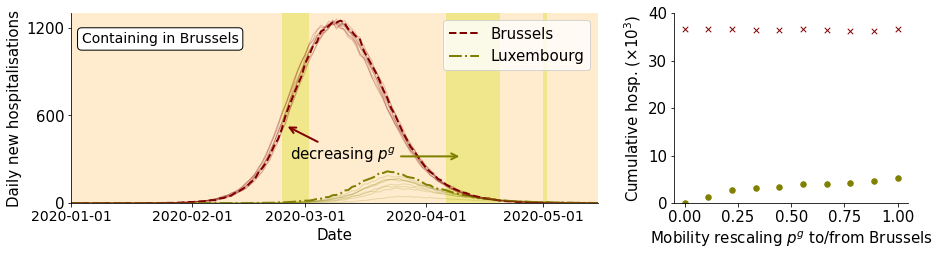

In [19]:
savefig=True
color_NIS1 = 'maroon'
color_NIS2 = 'olive'

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)

from matplotlib import gridspec as gs
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[9, 4]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ticklabelsize = 12
ax0.set_xlim(start_date, end_show)
# ax0.set_xlim(start_date, end_date)
ax0.set_ylim(0, 1300)
ax0.set_yticks([0, 600, 1200])
# ax0.set_ylim(0, 3250)

week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=ax0, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 2, 1).date(), pd.Timestamp(2020, 3, 1).date(), \
               pd.Timestamp(2020, 4, 1).date(), pd.Timestamp(2020, 5, 1).date()]

#########################
## original simulation ##
#########################

# Define values of pg
pg_values =  np.linspace(1, 0, n_mobility_values)
# Set mobility reduction to the first value of pg
model.parameters['p'] = pg_values[0]*np.ones(11)
# initialise sum array
sum_array_NIS1 = []
sum_array_NIS2 = []
# Simulate model
print(f'working on pg_value {pg_values[0]}.')
out = model.sim(end_date, start_date=start_date, N=n_repeats, l=1/2, processes=processes)
out['H_in'].sel(NIS=NIS1).sum(dim=['Nc', 'doses']).mean(dim='draws').plot(ax=ax0, color=color_NIS1, label='Brussels',
                                                        linewidth=2, linestyle='--')
out['H_in'].sel(NIS=NIS2).sum(dim=['Nc', 'doses']).mean(dim='draws').plot(ax=ax0, color=color_NIS2, label='Luxembourg',
                                                        linewidth=2, linestyle='-.')
# Attach to results
sum_NIS1 = float(out['H_in'].sel(NIS=NIS1).sum(dim=['Nc', 'doses']).mean(dim='draws').sum().values)
sum_array_NIS1.append(sum_NIS1)
sum_NIS2 = float(out['H_in'].sel(NIS=NIS2).sum(dim=['Nc', 'doses']).mean(dim='draws').sum().values)
sum_array_NIS2.append(sum_NIS2)

######################
## altered mobility ##
######################

for pg_value in pg_values[1:]:
    
    print(f'working on pg_value {pg_value}.')

    # Set correct value of p
    p = model.parameters['p']
    p[NIS1_idx] = pg_value
    model.parameters['p'] = p
    # run model
    out = model.sim(end_date, start_date=start_date, N=n_repeats, l=1/2, processes=processes)
    # Overplot with alpha
    out['H_in'].sel(NIS=NIS1).sum(dim=['Nc','doses']).mean(dim='draws').plot(ax=ax0, color=color_NIS1, linewidth=1, alpha=0.2)
    out['H_in'].sel(NIS=NIS2).sum(dim=['Nc', 'doses']).mean(dim='draws').plot(ax=ax0, color=color_NIS2, linewidth=1, alpha=0.2)
    # Attach to results
    sum_NIS2 = float(out['H_in'].sel(NIS=NIS2).sum(dim=['Nc', 'doses']).mean(dim='draws').sum().values)
    sum_array_NIS2.append(sum_NIS2)
    sum_NIS1 = float(out['H_in'].sel(NIS=NIS1).sum(dim=['Nc', 'doses']).mean(dim='draws').sum().values)
    sum_array_NIS1.append(sum_NIS1)

    ax0.set_title(None)
    ax0.grid(False)
    ticklabelsize = 14
    ax0.set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
    ax0.set_xlabel(None)
    ax0.set_ylabel('Daily hospitalisations')
    
s=30; linewidth=1
rescale = 1/1000
ax1.scatter(np.array(pg_values), np.array(sum_array_NIS1)*rescale, s=s, color=color_NIS1, marker='x', label='Brussels', linewidths=linewidth)
ax1.scatter(np.array(pg_values), np.array(sum_array_NIS2)*rescale, s=s, color=color_NIS2, marker='o', label='Luxembourg', linewidths=linewidth)
ax1.set_xscale('linear')
ax1.set_xlabel(f'Mobility rescaling $p^g$ to/from Brussels')
ax1.set_ylabel('Cumulative hosp. ($\\times10^3$)')
ax1.grid(False)


# ax0.set_title(None)
ax0.grid(False)
ticklabelsize = 14
ax0.legend(loc=1)
ax0.set_xlabel('Date')
ax0.set_ylabel('Daily new hospitalisations')
ax0.set_xticks(ticks=xticks)
ax0.set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')

if init_NIS==NIS2:
    ax0.text(0.02, 0.90, 'Shielding Brussels', transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    arrow_start = start_date + pd.Timedelta(days=30)
    arrow_end = start_date + pd.Timedelta(days=80)
    arrow_height = 600
    ax0.annotate(text='decreasing $p^g$', xytext=(arrow_start, arrow_height+100), xy=(arrow_end, arrow_height-350), \
                arrowprops=dict(arrowstyle='->', linewidth=2, color=color_NIS1))#, ls='dashed'))
    ax1.set_ylim([0,25])
    ax1.legend(loc=4)
    
elif init_NIS==NIS1:
    ax0.text(0.02, 0.90, 'Containing in Brussels', transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    arrow_start1 = start_date + pd.Timedelta(days=56)
    arrow_end1 = start_date + pd.Timedelta(days=55)
    arrow_start2 = start_date + pd.Timedelta(days=84)
    arrow_end2 = start_date + pd.Timedelta(days=100)
    ax0.annotate(text='decreasing $p^g$', xytext=(arrow_start1, 300), xy=(arrow_end1, 530), \
                arrowprops=dict(arrowstyle='->', linewidth=2, color=color_NIS1))#, ls='dashed'))
    ax0.annotate(text='', xytext=(arrow_start2, 320), xy=(arrow_end2, 320), \
                arrowprops=dict(arrowstyle='->', linewidth=2, color=color_NIS2))#, ls='dashed'))
    ax1.set_ylim([0,40])
    #ax1.legend(loc=4)
    
# fig.suptitle("Effect of manipulating mobility to/from Brussels")
if savefig:
    plt.savefig(f"mobility-reduction-to-{NIS1}_index-patients-in-{init_NIS}.pdf", bbox_inches='tight')